In [1]:
'''
https://www.kaggle.com/avijitghosh82/category-wise-analysis-usa
https://www.kaggle.com/ievgenvp/youtube-trends-eda/notebook
https://www.kaggle.com/avijitghosh82/category-wise-analysis-usa
https://www.kaggle.com/duanerich/eda-on-youtube-s-data
https://www.kaggle.com/ajayshelar/readability-analysis-of-youtube-titles
https://www.kaggle.com/ambllamas/exploring-trending-youtube-videos
'''

'\nhttps://www.kaggle.com/avijitghosh82/category-wise-analysis-usa\nhttps://www.kaggle.com/ievgenvp/youtube-trends-eda/notebook\nhttps://www.kaggle.com/avijitghosh82/category-wise-analysis-usa\nhttps://www.kaggle.com/duanerich/eda-on-youtube-s-data\nhttps://www.kaggle.com/ajayshelar/readability-analysis-of-youtube-titles\nhttps://www.kaggle.com/ambllamas/exploring-trending-youtube-videos\n'

In [2]:
'''
Técnicas Envolvidas
• Análise descritiva de dados.
• Classificação binária.
• Clustering.
Desafios
Para esse projeto, alguns desafios são:
• Classificação conforme like/dislike vinculado aos comentários, extrapolar like/dislike de quem comentou e não
classificou.
• Clustering baseado em comentários.
• Análise de mudança de sentimento no decorrer do tempo.
'''

'\nTécnicas Envolvidas\n• Análise descritiva de dados.\n• Classificação binária.\n• Clustering.\nDesafios\nPara esse projeto, alguns desafios são:\n• Classificação conforme like/dislike vinculado aos comentários, extrapolar like/dislike de quem comentou e não\nclassificou.\n• Clustering baseado em comentários.\n• Análise de mudança de sentimento no decorrer do tempo.\n'

## Imports

In [3]:
import pandas as pd
import numpy as np
from collections import Counter
import operator
import json
import matplotlib.pyplot as plt
%matplotlib inline

## Carregando os dados

### Categorias

In [4]:
f = open("data/US_category_id.json")
data = f.read()
f.close()
out = json.loads(data)
categories = pd.DataFrame([
    {'category_id':x['id'],
     'category':x['snippet']['title'],
     'assignable':x['snippet']['assignable']
    } for x in out['items']
])

In [5]:
categories.head()

,assignable,category,category_id
0,True,Film & Animation,1
1,True,Autos & Vehicles,2
2,True,Music,10
3,True,Pets & Animals,15
4,True,Sports,17


In [6]:
categories['category_id'] = categories['category_id'].astype(int)

### Vídeos e comentários (EN)

In [7]:
USvideos = pd.read_csv('data/USvideos.csv',error_bad_lines=False)
UScomments = pd.read_csv('data/UScomments.csv',error_bad_lines=False)

b'Skipping line 2401: expected 11 fields, saw 21\nSkipping line 2800: expected 11 fields, saw 21\nSkipping line 5297: expected 11 fields, saw 12\nSkipping line 5299: expected 11 fields, saw 12\nSkipping line 5300: expected 11 fields, saw 12\nSkipping line 5301: expected 11 fields, saw 12\n'
b'Skipping line 41589: expected 4 fields, saw 11\nSkipping line 51628: expected 4 fields, saw 7\nSkipping line 114465: expected 4 fields, saw 5\n'
b'Skipping line 142496: expected 4 fields, saw 8\nSkipping line 189732: expected 4 fields, saw 6\nSkipping line 245218: expected 4 fields, saw 7\n'
b'Skipping line 388430: expected 4 fields, saw 5\n'
/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Manipulando os dados

### Realizando *merge* das categorias com os vídeos

In [8]:
USvideos['category_id'] = USvideos['category_id'].astype(int)
USvideos['date'] = USvideos['date'].apply(lambda x: pd.to_datetime(str(x).replace('.','') + "2017", format='%d%m%Y'))
USvideos['date'] = USvideos['date'].dt.date
USvideos = USvideos.drop_duplicates()
USvideos = USvideos.merge(categories, on='category_id')

In [9]:
USvideos.head(3)

,video_id,title,channel_title,category_id,tags,views,likes,dislikes,comment_total,thumbnail_link,date,assignable,category
0,XpVt6Z1Gjjo,1 YEAR OF VLOGGING -- HOW LOGAN PAUL CHANGED Y...,Logan Paul Vlogs,24,logan paul vlog|logan paul|logan|paul|olympics...,4394029,320053,5931,46245,https://i.ytimg.com/vi/XpVt6Z1Gjjo/default.jpg,2017-09-13,True,Entertainment
1,4MkC65emkG4,Hand In Hand A Benefit For Hurricane Relief | MTV,MTV,24,mtv|video|online|official|tv|television|watch|...,274358,9215,477,838,https://i.ytimg.com/vi/4MkC65emkG4/default.jpg,2017-09-13,True,Entertainment
2,vu_9muoxT50,Colin Cloud: Mind Reader Predicts Your Tweets ...,America's Got Talent,24,America's Got Talent 2017|america's got talent...,473691,14740,415,1696,https://i.ytimg.com/vi/vu_9muoxT50/default.jpg,2017-09-13,True,Entertainment


## Criação e verificação de medidas: *enthusiasm* e *satisfaction*

Criamos duas medidas: $enthusiasm$ e $satisfaction$:

$ enthusiasm = \frac{\sum likes}{\sum likes + \sum dislikes} $

$satisfaction = \frac{\sum likes - \sum dislikes}{\sum views }$

A medida $satisfaction$ foi normalizada com *z-norm*: $z_i=\frac{x_i-\min(x)}{\max(x)-\min(x)}$

In [10]:
USvideos['enthusiasm'] = USvideos['likes'] / (USvideos['likes'] + USvideos['dislikes']) # criando uma nova coluna enthusiasm (medica como a porcentagem de likes sobre os like/dislike)
USvideos['satisfaction'] = (USvideos['likes'] - USvideos['dislikes']) / USvideos['views'] # criação de uma medida de satisfação, (os que gostaram - os que não gostaram) / total
USvideos['satisfaction'] = (USvideos['satisfaction'] - min(USvideos['satisfaction']))/(max(USvideos['satisfaction']) - min(USvideos['satisfaction']))

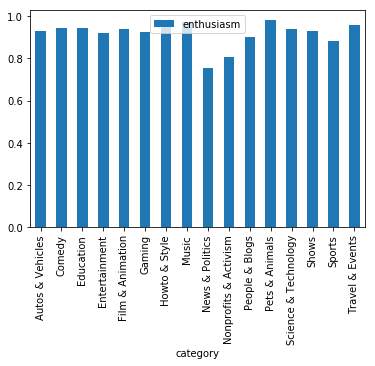

In [11]:
CatAverageEnthusiasm = USvideos.groupby(['category'])['enthusiasm'].mean() # median
enthusiasmDF = CatAverageEnthusiasm.to_frame() #.sort_values(['enthusiasm'])
enthusiasmDF.plot(kind = 'bar')

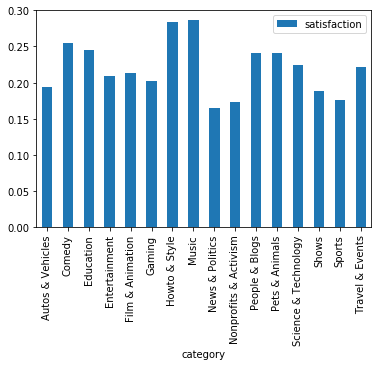

In [12]:
CatAverageSatisfaction = USvideos.groupby(['category'])['satisfaction'].median() # median
satisfactionDF = CatAverageSatisfaction.to_frame()
satisfactionDF.plot(kind = 'bar')

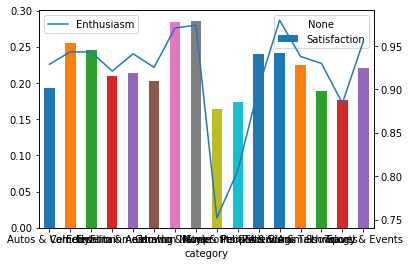

In [13]:
# TODO: ORGANIZAR LEGENDA E EIXO X NA VERTICAL
satisfactionDF.satisfaction.plot(kind='bar').legend(['Satisfaction'])
enthusiasmDF.enthusiasm.plot(kind='line', secondary_y = True).legend(['Enthusiasm'])

In [14]:
measures = pd.concat([enthusiasmDF, satisfactionDF],  axis=1, join='inner')

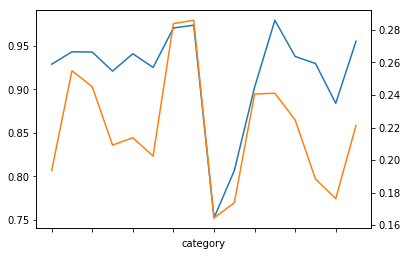

In [15]:
measures.enthusiasm.plot()
measures.satisfaction.plot(secondary_y=True)

In [16]:
measures.corr()

,enthusiasm,satisfaction
enthusiasm,1.000000,0.732706
satisfaction,0.732706,1.000000


Avaliamos que a correlação entre $enthusiasm$ e $satisfaction$ é de $73,27\%$

## Tags

In [17]:
tagsDF = pd.DataFrame()

In [18]:
%%time
for idx in range(len(USvideos)):
    tags = list(set(USvideos.tags[idx].lower().split('|')))
    tagsDF = tagsDF.append(pd.DataFrame({'tag': tags, 'category_id': [USvideos.category_id[idx]] * len(tags)}))

CPU times: user 23.2 s, sys: 43.7 ms, total: 23.2 s
Wall time: 23.2 s


In [19]:
tagsDF.head()

,category_id,tag
0,24,youtube button
1,24,paul
2,24,maverick
3,24,daily
4,24,logan paul vlog


In [20]:
tagsGroupDF = tagsDF.groupby(['category_id', 'tag']).tag.agg('count').rename(columns={'tag':'tag_count'}).to_frame().reset_index()
tagsGroupDF = tagsGroupDF.rename(columns={0: "count"})

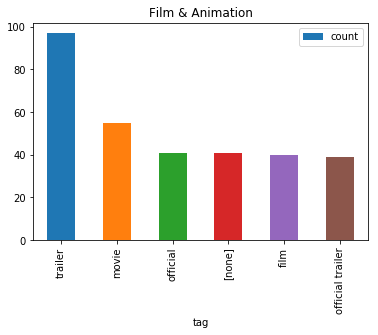

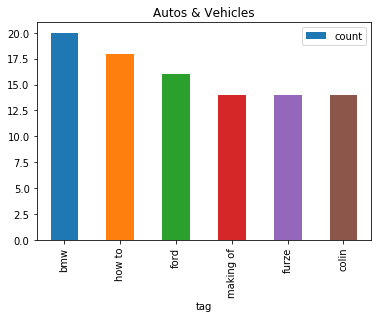

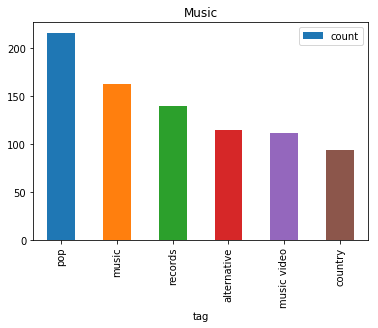

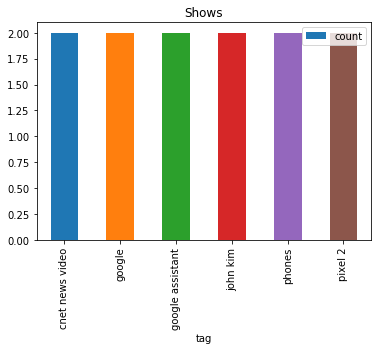

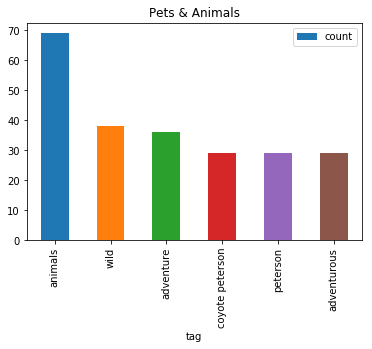

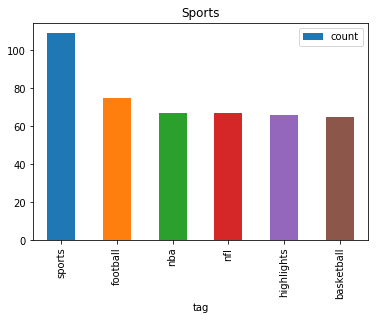

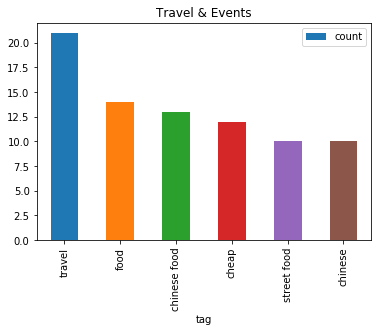

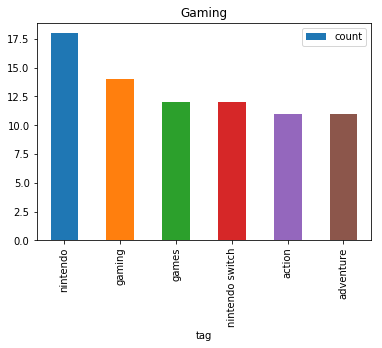

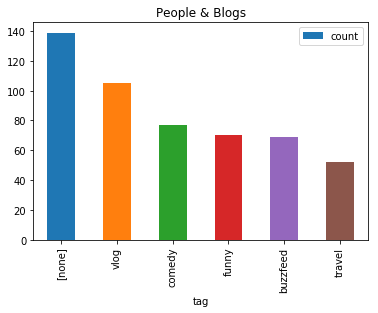

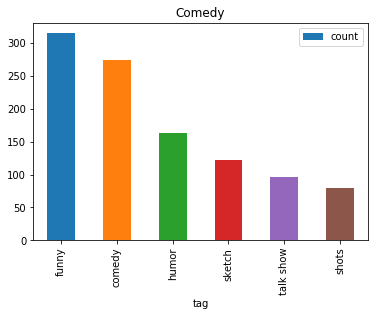

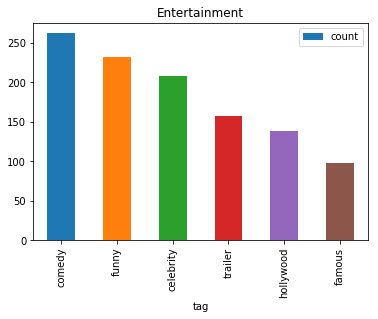

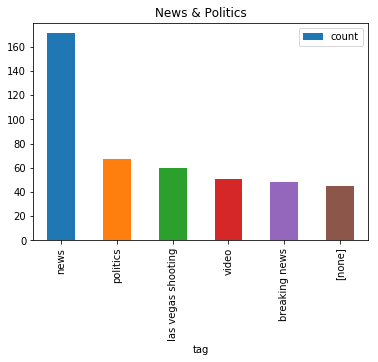

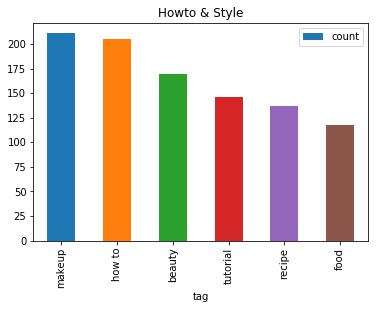

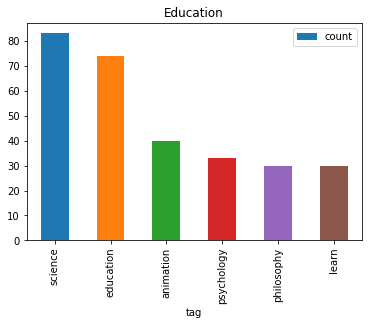

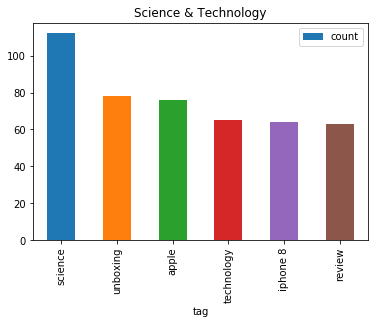

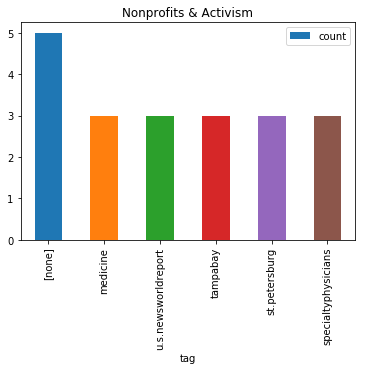

In [21]:
for cat in list(set(tagsGroupDF.category_id)):
    title = categories.loc[categories["category_id"] == cat].category.any()
    curCatDF = tagsGroupDF.loc[tagsGroupDF['category_id'] == cat]
    curCatDF.sort_values('count', ascending = False).head(6).plot(
        x = 'tag', 
        y = 'count', 
        kind = 'bar',
        title = title)

In [22]:
CFDDates = sorted(list(set(USvideos.date)))
CFDCategory = list(set(USvideos.category_id))

In [56]:
CFDUniqueCount = pd.DataFrame({'category_id': list(set(USvideos.category_id))})
sum_temp = None
last_date = None
for item in CFDDates:
    preProcessed = USvideos.loc[USvideos['date'] == item]
    preProcessedGrouped = preProcessed.groupby(['category_id', 'date']).date.agg('count').rename(columns={'date':'data_count'}).to_frame().reset_index().rename(columns={0: "count"})
    temp = pd.DataFrame({str(item): preProcessedGrouped['count']})
    sum_temp = pd.concat([sum_temp, temp], axis=1).fillna(0).sum(axis=1)
    if last_date and last_date.month != item.month:
        CFDUniqueCount = CFDUniqueCount.join(pd.DataFrame({last_date.strftime('%Y-%m'): sum_temp}))
        sum_temp = None
    last_date = item
CFDUniqueCount = CFDUniqueCount.join(pd.DataFrame({last_date.strftime('%Y-%m'): sum_temp}))

In [57]:
# TODO: SOMA RETROATIVA
CFDUniqueCount

,category_id,2017-01,2017-09
0,1,178.0,200.0
1,2,86.0,50.0
2,10,699.0,535.0
3,43,76.0,47.0
4,15,249.0,151.0
5,17,48.0,25.0
6,19,239.0,126.0
7,20,460.0,366.0
8,22,660.0,381.0
9,23,680.0,566.0


In [25]:
CFDCount.T.plot()

NameError: name 'CFDCount' is not defined